
# Random Forest Classifier

+ basic sklearn calls
+ show that increasing number of trees or tree depth does npt overtrain
+ including irrelevant features might decrease performance


In [1]:
import numpy as np
import pylab as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
Dp0=pd.read_csv('../datasets/S_MPOS_27_100',delimiter=" ",header=None)
Dn0=pd.read_csv('../datasets/S_MNEG_27_100',delimiter=" ",header=None)

Dp0s=Dp0
Dn0s=Dn0.sample(Dp0s.index.size)
Dn0s=Dn0.sample(2000)


D=pd.concat([Dp0s,Dn0s])
y=np.append(np.zeros([Dp0s.index.size,1]),np.ones([Dn0s.index.size,1]))

X=D.values

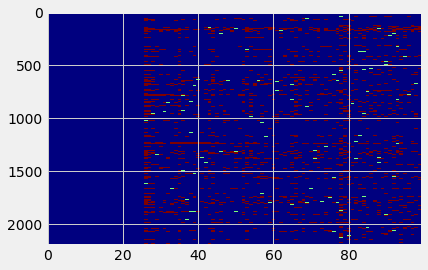

In [3]:
plt.imshow(X,aspect='auto',cmap='jet');

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
clf = RandomForestClassifier(max_depth=10, class_weight='balanced',n_estimators=100)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"% (y_test.shape[0],(y_test != y_pred).sum()))

acc=clf.score(X_test,y_test)
y_pred=clf.predict_proba(X_test)
y_pred_insample=clf.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
fpr_insample, tpr_insample, thresholds_insample = metrics.roc_curve(y_train,y_pred_insample[:,1], pos_label=1)
auc=metrics.auc(fpr, tpr)
auc_insample=metrics.auc(fpr_insample, tpr_insample)

print('Accuracy: ',acc,'AUC oos: ',auc,'AUC in sample: ',auc_insample)

Number of mislabeled points out of a total 1102 points : 513
Accuracy:  0.5344827586206896 AUC oos:  0.533077356935225 AUC in sample:  0.8645778439683812


In [5]:
clf.estimators_[:5]

[DecisionTreeClassifier(max_depth=10, max_features='auto',
                        random_state=1299974766),
 DecisionTreeClassifier(max_depth=10, max_features='auto',
                        random_state=2067186540),
 DecisionTreeClassifier(max_depth=10, max_features='auto',
                        random_state=1565654063),
 DecisionTreeClassifier(max_depth=10, max_features='auto',
                        random_state=1420876796),
 DecisionTreeClassifier(max_depth=10, max_features='auto',
                        random_state=906248863)]

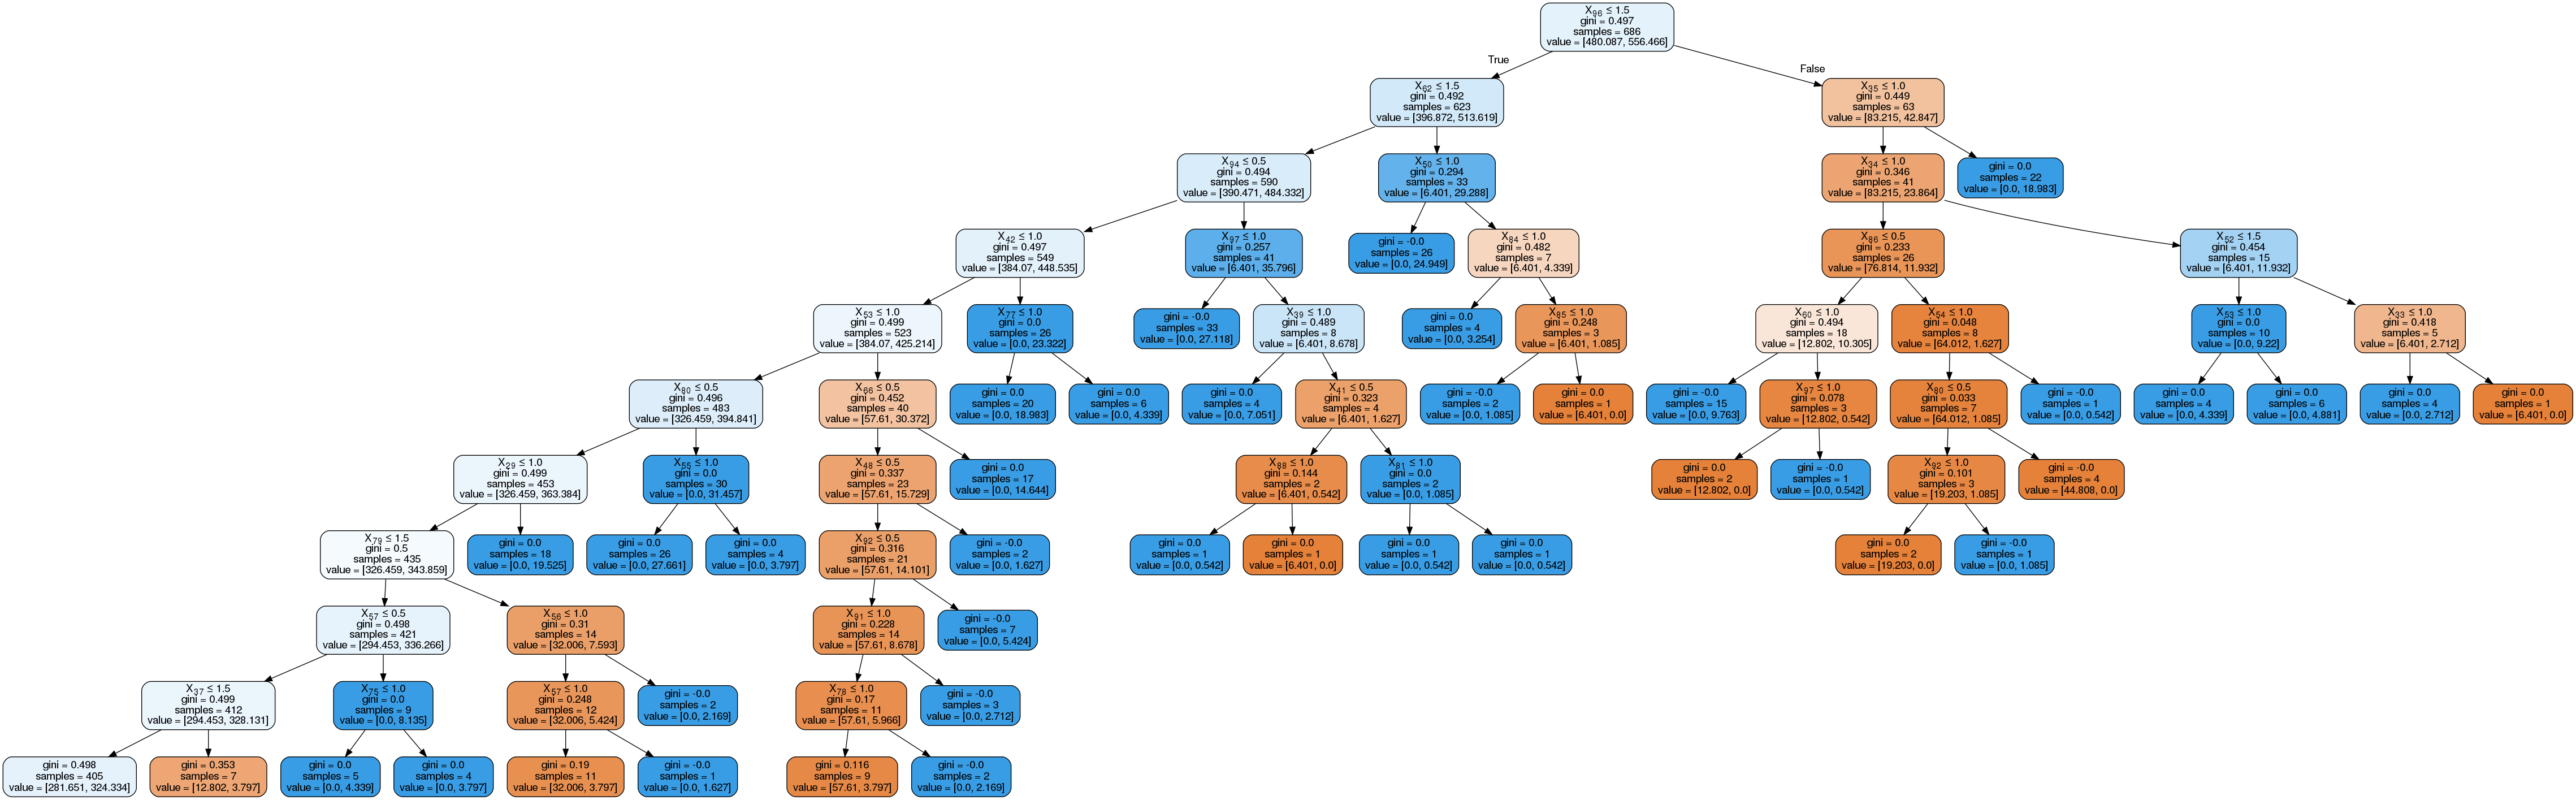

In [6]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from subprocess import call

count=3
dot_data = StringIO()
export_graphviz(clf.estimators_[count], out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
#export_graphviz(clf.estimators_[count], out_file='bagging_tree'+str(count)+'.dot',
#                filled=True, rounded=True,
#                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png(), width=1900, unconfined=True)

#call(['dot', '-Tpng', 'bagging_tree'+str(count)+'.dot', '-o', 'PSYtree'+str(count)+'.png', '-Gdpi=600'])


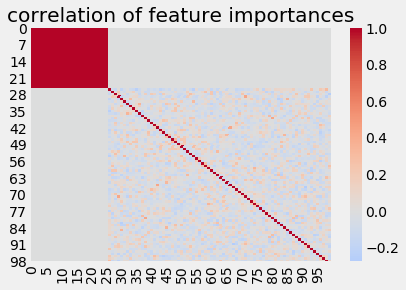

In [7]:
FI={}
count=0
for i in clf.estimators_:
    FI[count]=i.feature_importances_
    count=count+1
FI=pd.DataFrame(FI)
cFI=np.corrcoef(FI.fillna(0).values+0.00001)
ax=sns.heatmap(cFI,cmap='coolwarm',center=0)
ax.set_title('correlation of feature importances');

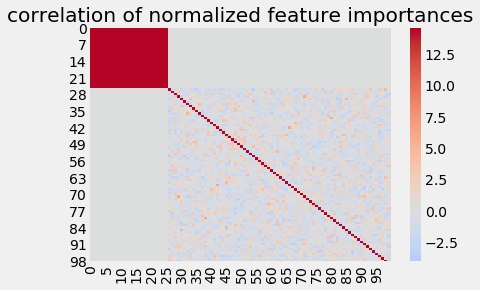

In [8]:
cFI_=pd.DataFrame(cFI).fillna(0)
cFI_.mean().mean()
ax=sns.heatmap(cFI_/cFI_.mean().mean(),cmap='coolwarm',center=0)
ax.set_title('correlation of normalized feature importances');

In [17]:
# check how much the performance varies by random splits (variance)
RUNS=50
P=[]
for run in tqdm(np.arange(RUNS)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    clf = RandomForestClassifier(max_depth=None, class_weight='balanced',n_estimators=100)

    y_pred = clf.fit(X_train, y_train).predict(X_test)
    acc=clf.score(X_test,y_test)
    y_pred=clf.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
    auc=metrics.auc(fpr, tpr)
    P=np.append(P,[acc,auc])
P=P.reshape(int(len(P)/2),2)

100%|██████████| 50/50 [00:12<00:00,  3.96it/s]


0.5627846950505944


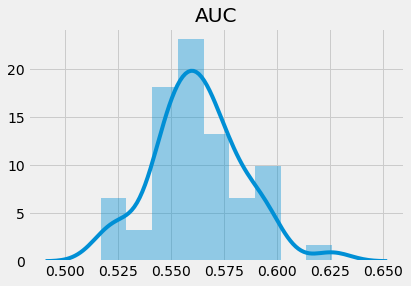

In [18]:
#auc
ax=sns.distplot(P[:,1])
ax.set_title('AUC')
print(P[:,1].mean())

Text(0.5, 1.0, 'accuracy')

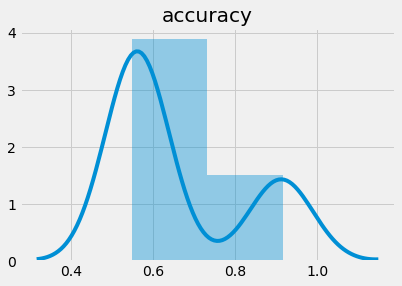

In [19]:
#acc
ax=sns.distplot(P[:,0])
ax.set_title('accuracy')

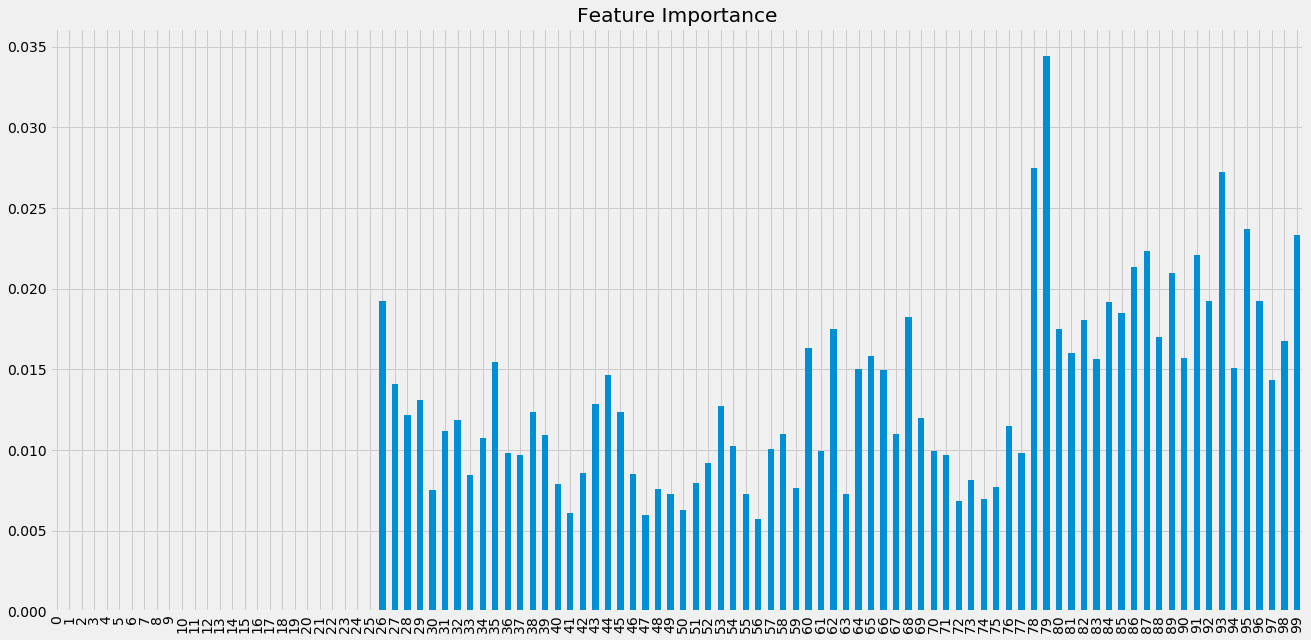

In [20]:
# compute feature importance
plt.figure(figsize=[20,10])
FI={}
count=0
for i in clf.estimators_:
    FI[count]=np.array(i.feature_importances_)
    count=count+1
#FI=FI/len(clf.estimators_)
ax=pd.DataFrame(FI).mean(axis=1).plot(kind='bar')
ax.set_title('Feature Importance');

In [21]:
# check how much the performance varies by random splits (variance)
RUNS=50
P=[]
for run in tqdm(np.arange(RUNS)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    clf = RandomForestClassifier(max_depth=None, class_weight='balanced',n_estimators=500)

    y_pred = clf.fit(X_train, y_train).predict(X_test)
    acc=clf.score(X_test,y_test)
    y_pred=clf.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
    auc=metrics.auc(fpr, tpr)
    P=np.append(P,[acc,auc])
P=P.reshape(int(len(P)/2),2)

100%|██████████| 50/50 [01:04<00:00,  1.30s/it]


0.5864529427227759


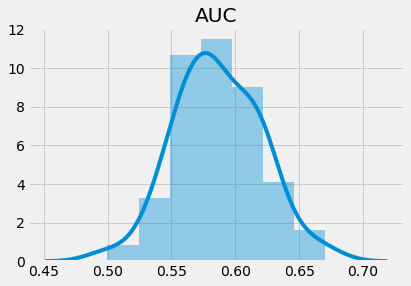

In [22]:
#auc
ax=sns.distplot(P[:,1])
ax.set_title('AUC')
print(P[:,1].mean())

Text(0.5, 1.0, 'accuracy')

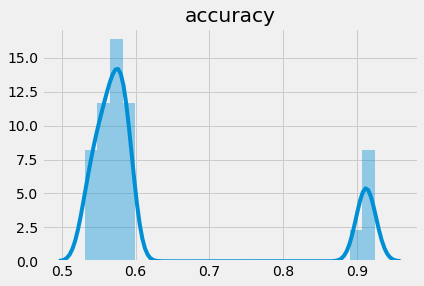

In [23]:
#acc
ax=sns.distplot(P[:,0])
ax.set_title('accuracy')

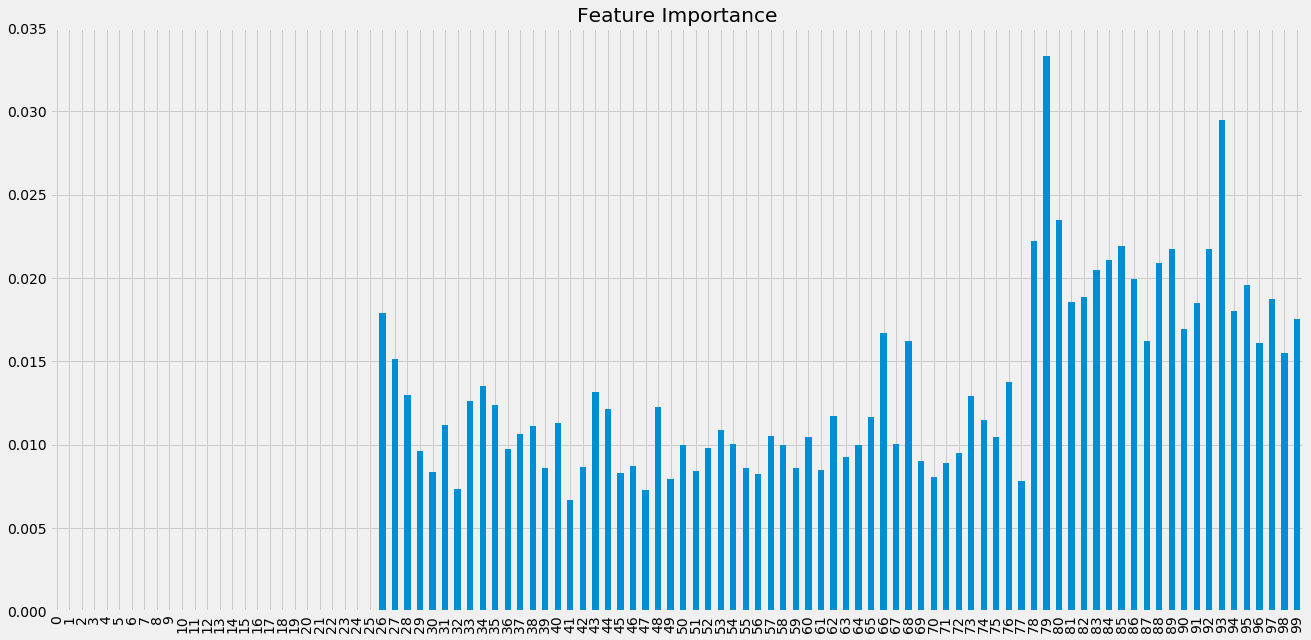

In [24]:
# compute feature importance
plt.figure(figsize=[20,10])
FI={}
count=0
for i in clf.estimators_:
    FI[count]=np.array(i.feature_importances_)
    count=count+1
#FI=FI/len(clf.estimators_)
ax=pd.DataFrame(FI).mean(axis=1).plot(kind='bar')
ax.set_title('Feature Importance');